# MLP GenCode 
Extend MLP_GenCode_105 to show all the stats shown in Wen et al 2019. Here, add AUC for the best model. Still need to add precison, recall, F1, and average test accuracy per fold of training. For now, for comparison to 105, run this on CoLab with a larger validation set. 

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-16 11:23:42 UTC


In [2]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=8000
NC_TESTS=8000   # Wen et al 2019 used 8000 and 2000 of each class
PC_LENS=(200,4000)
NC_LENS=(250,3000)    # Wen et al 2019 used 250-3500 for lncRNA only
MAX_K = 3
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
EPOCHS=25
SPLITS=5
FOLDS=5   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [5]:
PC_FILENAME='gencode.v26.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v26.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME

In [6]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(False)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 95146
NC seqs loaded: 27720
2021-07-16 11:24:11 UTC


## Data Prep

In [7]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_shuffle(df):
    # The ignore_index option is new in Pandas 1.3. 
    # The default (False) replicates the old behavior: shuffle the index too.
    # The new option seems more logical th
    # After shuffling, df.iloc[0] has index == 0.
    # return df.sample(frac=1,ignore_index=True)
    return df.sample(frac=1)  # Use this till CoLab upgrades Pandas
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    dataframe_shuffle(
    dataframe_length_filter(pcdf,PC_LENS)))
nc_all = dataframe_extract_sequence(
    dataframe_shuffle(
    dataframe_length_filter(ncdf,NC_LENS)))

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-16 11:24:11 UTC
PC seqs pass filter: 82256
NC seqs pass filter: 25755


In [8]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None

PC train, NC train: 8000 8000
PC test, NC test: 8000 8000


In [9]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    all_labels = np.concatenate((L1,L0))
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_seqs = np.concatenate((S1,S0))  
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
# Tests:
#Xseq,y=prepare_x_and_y(['CAAAA','CCCCC','AAAAA','AAACC','CCCAA'],
#                       ['GGGGG','TTTTT','GGGTT','GGGTG','TTGTG'])
show_time()

2021-07-16 11:24:11 UTC


In [10]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
show_time()

2021-07-16 11:24:20 UTC


## Neural network

In [11]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    #dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
400/400 [==============================] - 14s 3ms/step - loss: 0.6692 - accuracy: 0.6126 - val_loss: 0.8206 - val_accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6645 - accuracy: 0.6287 - val_loss: 0.8923 - val_accuracy: 0.0000e+00
Epoch 3/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6616 - accuracy: 0.6317 - val_loss: 1.2032 - val_accuracy: 0.0000e+00
Epoch 4/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6652 - accuracy: 0.6241 - val_loss: 0.9918 - val_accuracy: 0.0000e+00
Epoch 5/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6636 - accuracy: 0.6238 - val_loss: 1.0299 - val_accuracy: 0.0000e+00
Epoch 6/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6633 - accuracy: 0.6236 - val_loss: 1.0112 - val_accuracy: 0.0000e+00
Epoch 7/25
400/400 [========

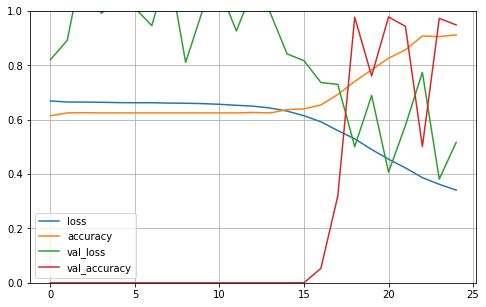

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
400/400 [==============================] - 2s 3ms/step - loss: 0.6678 - accuracy: 0.6250 - val_loss: 1.0614 - val_accuracy: 0.0000e+00
Epoch 2/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6668 - accuracy: 0.6215 - val_loss: 0.9658 - val_accuracy: 0.0000e+00
Epoch 3/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6669 - accuracy: 0.6192 - val_loss: 0.9941 - val_accuracy: 0.0000e+00
Epoch 4/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6665 - accuracy: 0.6189 - val_loss: 0.9164 - val_accuracy: 0.0000e+00
Epoch 5/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6669 - accuracy: 0.6178 - val_loss: 1.1147 - val_accuracy: 0.0000e+00
Epoch 6/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6624 - accuracy: 0.6253 - val_loss: 0.8558 - val_accuracy: 0.0000e+00
Epoch 7/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6610 

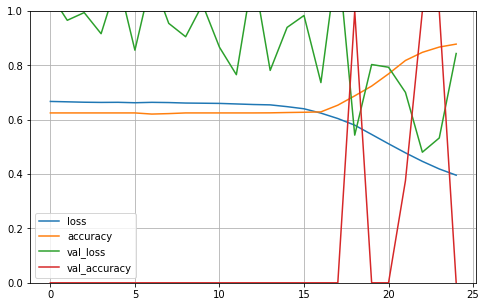

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
400/400 [==============================] - 2s 3ms/step - loss: 0.7009 - accuracy: 0.5020 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6994 - accuracy: 0.4933 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 3/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6973 - accuracy: 0.4874 - val_loss: 0.7071 - val_accuracy: 0.5000
Epoch 4/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6974 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6947 - accuracy: 0.4977 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5139 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 7/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5053 - val

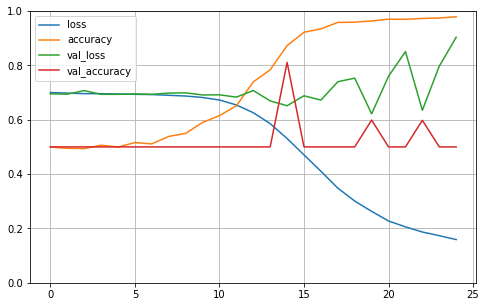

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
400/400 [==============================] - 2s 3ms/step - loss: 0.6687 - accuracy: 0.6240 - val_loss: 0.9737 - val_accuracy: 0.0000e+00
Epoch 2/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6677 - accuracy: 0.6176 - val_loss: 1.2737 - val_accuracy: 0.0000e+00
Epoch 3/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6661 - accuracy: 0.6251 - val_loss: 1.0833 - val_accuracy: 0.0000e+00
Epoch 4/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6646 - accuracy: 0.6257 - val_loss: 0.9379 - val_accuracy: 0.0000e+00
Epoch 5/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6651 - accuracy: 0.6187 - val_loss: 0.9535 - val_accuracy: 0.0000e+00
Epoch 6/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6577 - accuracy: 0.6348 - val_loss: 1.0624 - val_accuracy: 0.0000e+00
Epoch 7/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6626 

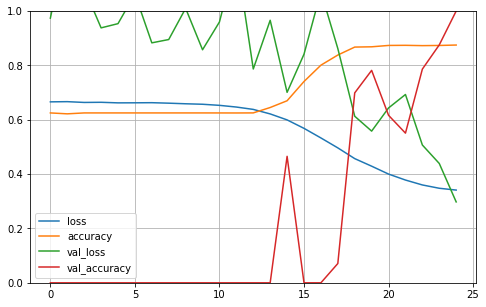

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
400/400 [==============================] - 2s 3ms/step - loss: 0.6671 - accuracy: 0.6235 - val_loss: 0.9139 - val_accuracy: 0.0000e+00
Epoch 2/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6678 - accuracy: 0.6197 - val_loss: 1.0891 - val_accuracy: 0.0000e+00
Epoch 3/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6701 - accuracy: 0.6184 - val_loss: 0.9530 - val_accuracy: 0.0000e+00
Epoch 4/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6666 - accuracy: 0.6201 - val_loss: 1.2120 - val_accuracy: 0.0000e+00
Epoch 5/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6689 - accuracy: 0.6183 - val_loss: 1.0523 - val_accuracy: 0.0000e+00
Epoch 6/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6670 - accuracy: 0.6164 - val_loss: 0.9196 - val_accuracy: 0.0000e+00
Epoch 7/25
400/400 [==============================] - 1s 2ms/step - loss: 0.6610 

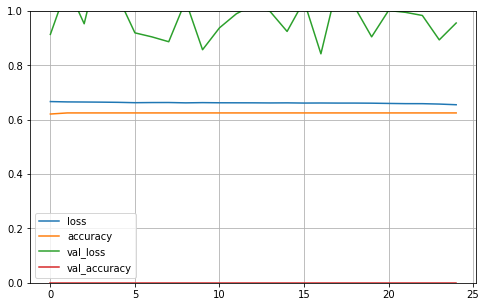

In [13]:
do_cross_validation(Xfrq,y)

In [14]:
from keras.models import load_model
print(pc_train[0])
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[0])
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[0])
X=Xfrq
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

AGATTTGCATAAAAAAGGCCAAGAAAACTCTGGCTGTGCCCCAGCAACGGCTCATTCTGCTCCCCCGGGTCGGAGCCCCCCGGAGCTGCGCGCGGGCTTGCAGCGCCTCGCCCGCGCTGTCCTCCCGGTGTCCCGCTTCTCCGCGCCCCAGCCGCCGGCTGCCAGCTTTTCGGGGCCCCGAGTCGCACCCAGCGAAGAGAGCGGGCCCGGGACAAGCTCGAACTCCGGCCGCCTCGCCCTTCCCCGGCTCCGCTCCCTCTGCCCCCTCGGGGTCGCGCGCCCACGATGCTGCAGGGCCCTGGCTCGCTGCTGCTGCTCTTCCTCGCCTCGCACTGCTGCCTGGGCTCGGCGCGCGGGCTCTTCCTCTTTGGCCAGCCCGACTTCTCCTACAAGCGCAGCAATTGCAAGCCCATCCCTGCCAACCTGCAGCTGTGCCACGGCATCGAATACCAGAACATGCGGCTGCCCAACCTGCTGGGCCACGAGACCATGAAGGAGGTGCTGGAGCAGGCCGGCGCTTGGATCCCGCTGGTCATGAAGCAGTGCCACCCGGACACCAAGAAGTTCCTGTGCTCGCTCTTCGCCCCCGTCTGCCTCGATGACCTAGACGAGACCATCCAGCCATGCCACTCGCTCTGCGTGCAGGTGAAGGACCGCTGCGCCCCGGTCATGTCCGCCTTCGGCTTCCCCTGGCCCGACATGCTTGAGTGCGACCGTTTCCCCCAGGACAACGACCTTTGCATCCCCCTCGCTAGCAGCGACCACCTCCTGCCAGCCACCGAGGAAGCTCCAAAGGTATGTGAAGCCTGCAAAAATAAAAATGATGATGACAACGACATAATGGAAACGCTTTGTAAAAATGATTTTGCACTGAAAATAAAAGTGAAGGAGATAACCTACATCAACCGAGATACCAAAATCATCCTGGAGACCAAGAGCAAGACCATTTACAAGCTGAACGGTGTGTCCGAAAGGGACCTGAAGAAATCGGTGCTGTGGC

predictions.shape (16000, 1)
first prediction [0.75937915]


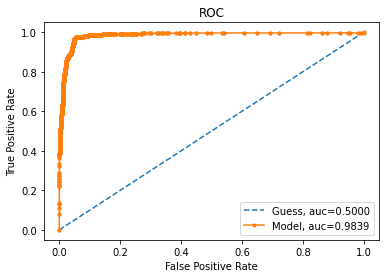

AUC: 98.39%


In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
print("predictions.shape",bm_probs.shape)
print("first prediction",bm_probs[0])
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))
